<font face="Chalkboard" color="darkgreen" size=6> Locally Weighted Linear Regression (part 2)</font>

The main idea is that we want to use many different kernels for the weights and compare the results.

In [1]:
import numpy as np
import pandas as pd
from math import ceil
from scipy import linalg
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Definition of the kernels:
https://en.wikipedia.org/wiki/Kernel_(statistics)

In [3]:
x = np.arange(-1.5,1.51,0.01)

In [ ]:
x

In [5]:
# Tricubic Kernel
def tricubic(x):
  return np.where(np.abs(x)>1,0,70/81*(1-np.abs(x)**3)**3)

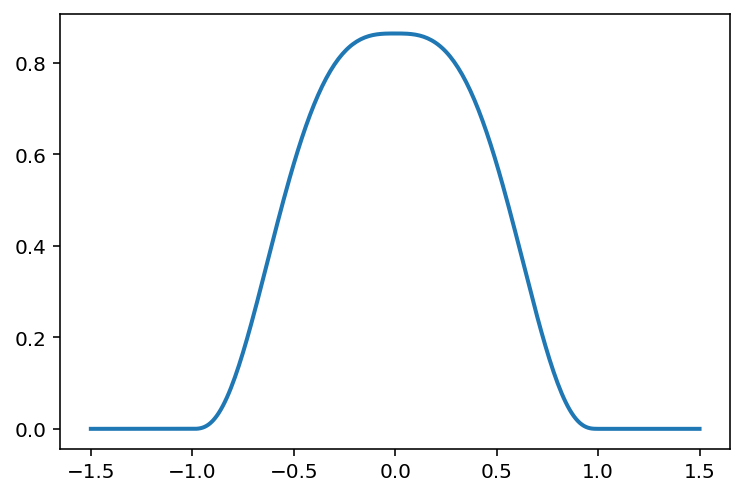

In [6]:
y = tricubic(x)
fig, ax = plt.subplots()
ax.plot(x,y,lw=2)
plt.show()

In [7]:
# Epanechnikov Kernel
def Epanechnikov(x):
  return np.where(np.abs(x)>1,0,3/4*(1-np.abs(x)**2)) 

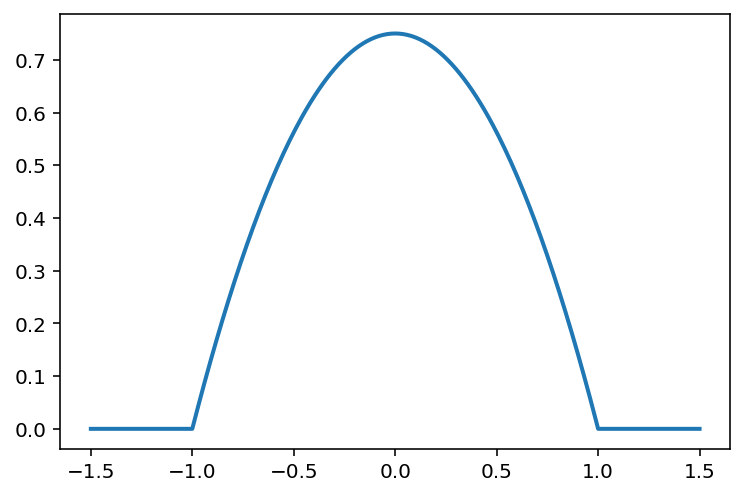

In [8]:
y = Epanechnikov(x)
fig, ax = plt.subplots()
ax.plot(x,y,lw=2)
plt.show()

In [9]:
# Quartic Kernel
def Quartic(x):
  return np.where(np.abs(x)>1,0,15/16*(1-np.abs(x)**2)**2) 

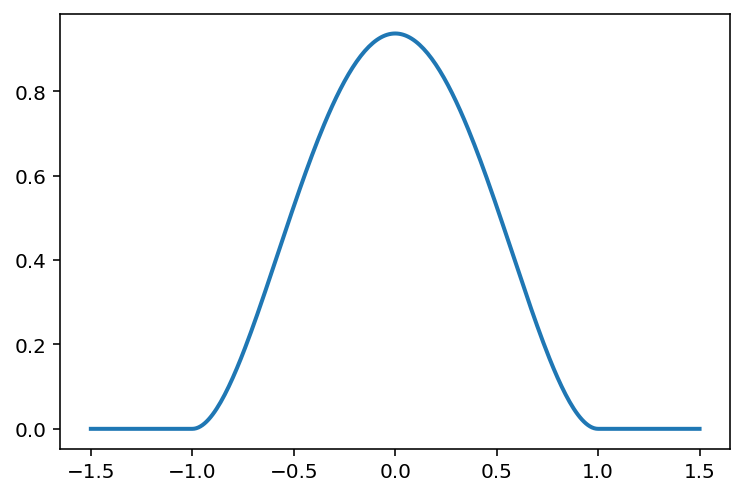

In [10]:
y = Quartic(x)
fig, ax = plt.subplots()
ax.plot(x,y,lw=2)
plt.show()

And the list of useful kernels may continue..

What we want is to apply different kernels to Locally Weighted Regression. We want to turn weak learners into strong ones.

In [17]:
#Defining the kernel function - used for plotting later on
kern = tricubic

def kernel_function(xi,x0,tau): 
    return kern((xi - x0)/(2*tau))

def lowess_kern(x, y, tau):

    # tau is called bandwidth K((x-x[i])/(2*tau))
    """lowess_bell_shape_kern(x, y, tau = .005) -> yest
    Locally weighted regression: fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The kernel function is the bell shaped function with parameter tau. Larger tau will result in a
    smoother curve. 
    """
    n = len(x)
    yest = np.zeros(n)

    #Initializing all weights from the bell shape kernel function    
    w = np.array([kern((x - x[i])/(2*tau)) for i in range(n)])     
    
    #Looping through all x-points
    for i in range(n):
        weights = w[:, i]
        b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
        A = np.array([[np.sum(weights), np.sum(weights * x)],
                    [np.sum(weights * x), np.sum(weights * x * x)]])
        theta = linalg.solve(A, b)
        yest[i] = theta[0] + theta[1] * x[i] 

    return yest

In [13]:
# approach by Alex Gramfort

def lowess_ag(x, y, f=2. / 3., iter=3):
    """lowess(x, y, f=2./3., iter=3) -> yest
    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    n = len(x)
    r = int(ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    yest = np.zeros(n)
    delta = np.ones(n)
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
            beta = linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return yest

In [20]:
from sklearn.linear_model import LinearRegression

In [22]:
#Initializing noisy non linear data
x = np.linspace(0,4,400)
noise = np.random.normal(loc = 0, scale = .4, size = 400)
y = np.sin(x * 1.5 * np.pi ) 
y_noise = y + noise

In [27]:
xlr = x.reshape(-1,1)
y_noiselr = y_noise.reshape(-1,1)

In [28]:
lr = LinearRegression()
lr.fit(xlr,y_noiselr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [30]:
# we want to compare with linear regression
yhat_lr = lr.predict(xlr)

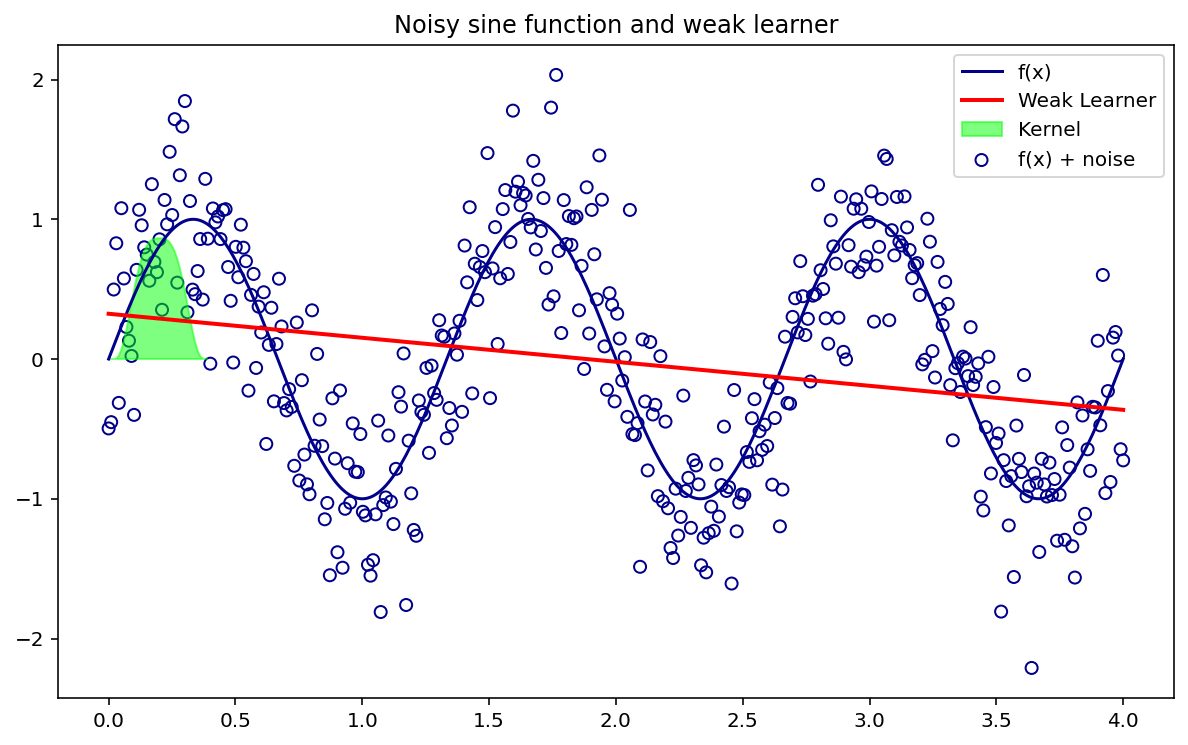

In [34]:




#Plotting the noisy data and the kernell at around x = 0.2
plt.figure(figsize=(10,6))
plt.plot(x,y,color = 'darkblue', label = 'f(x)')
plt.plot(xlr,yhat_lr,color='red',lw=2,label = 'Weak Learner')
plt.scatter(x,y_noise, facecolors = 'none', edgecolor = 'darkblue', label = 'f(x) + noise')
plt.fill(x[:40],kernel_function(x[:40],0.2,.09), color = 'lime', alpha = .5, label = 'Kernel')
plt.legend()
plt.title('Noisy sine function and weak learner')
plt.show()

In [18]:
## here is where we make predictions with our kernel
tau = 0.03

yhat_kern = lowess_kern(x,y,tau)

f = 0.25
yest = lowess_ag(x, y, f=f, iter=3)

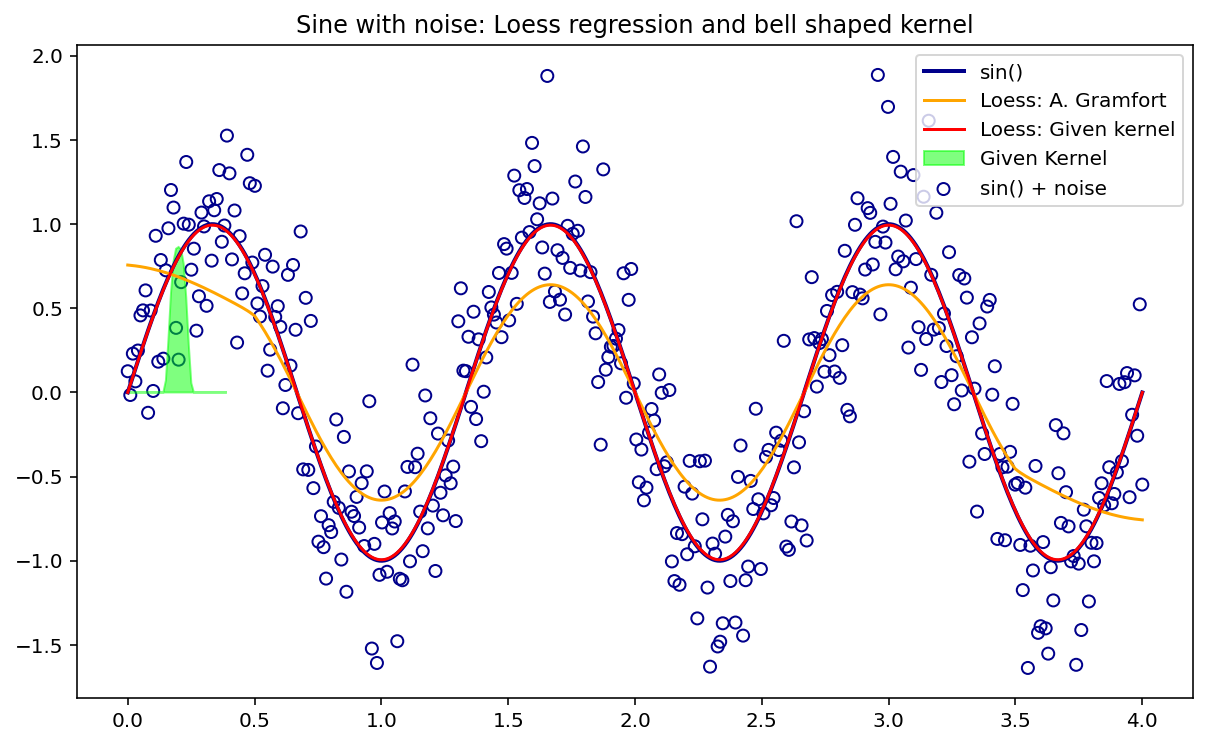

In [19]:
plt.figure(figsize=(10,6))
plt.plot(x,y,color = 'darkblue', label = 'sin()',lw=2)
plt.scatter(x,y_noise, facecolors = 'none', edgecolor = 'darkblue', label = 'sin() + noise')
plt.fill(x[:40],kernel_function(x[:40],0.2,tau), color = 'lime', alpha = .5, label = 'Given Kernel')
plt.plot(x,yest,color = 'orange', label = 'Loess: A. Gramfort')
plt.plot(x,yhat_kern,color = 'red', label = 'Loess: Given kernel')
plt.legend()
plt.title('Sine with noise: Loess regression and kernel')
plt.show()